In [2]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import unittest

In [3]:
# Step 1: Loading the Dataset
def load_data(file_path):
    """Load dataset from a CSV file."""
    data = pd.read_csv(file_path, encoding='ISO-8859-1')
    return data



In [4]:
def preprocess_data(data):
    """Clean and preprocess the data."""
    data.fillna(method='ffill', inplace=True)  # Forward fill for simplicity
    data = pd.get_dummies(data, columns=['gender', 'country', 'language'])  # One-hot encoding
    
    return data



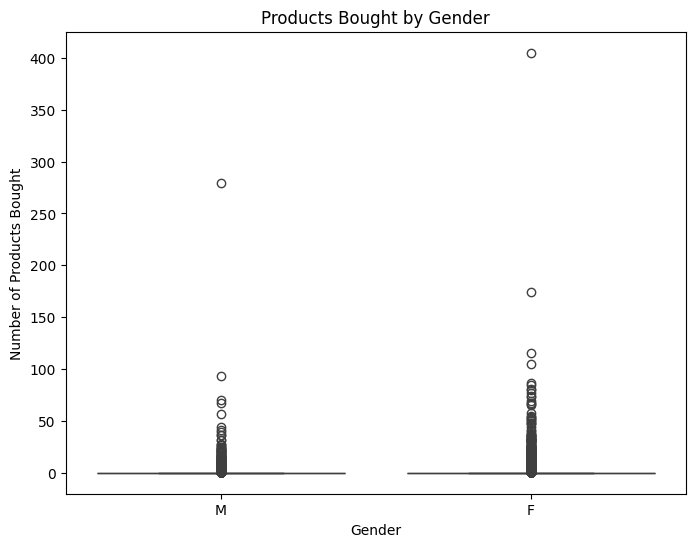

  gender  productsBought
0      F        0.167418
1      M        0.186995


In [5]:
data = pd.read_csv('6M-0K-99K.users.dataset.public.csv', encoding='ISO-8859-1')
# print(data.info())  # General information about the dataset
# print(data.describe()) 
# Boxplot of Products Bought by Gender
plt.figure(figsize=(8, 6))
sns.boxplot(x='gender', y='productsBought', data=data)
plt.title('Products Bought by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Products Bought')
plt.show()

# Average Products Bought by Gender
avg_products_by_gender = data.groupby('gender')['productsBought'].mean().reset_index()
print(avg_products_by_gender)

In [6]:
class UserAgent(Agent):
    """An agent representing a user with demographics."""
    
    def __init__(self, unique_id, model, demographics,purchase_prob_female_range=(0.3, 0.6), purchase_prob_male_range=(0.2, 0.5)):
        super().__init__(model)
        
        # Gender
        self.gender_male = demographics.get('gender_M', 0)
        self.gender_female = demographics.get('gender_F', 0)
        
        # Countries (assuming you have columns like country_Afrique du Sud, etc.)
        self.country_afrique_du_sud = demographics.get('country_Afrique du Sud', 0)
        self.country_albanie = demographics.get('country_Albanie', 0)
        # Add similar lines for other countries...

        # Languages
        self.language_de = demographics.get('language_de', 0)
        self.language_en = demographics.get('language_en', 0)
        # Add similar lines for other languages...

        self.login_frequency = random.randint(1, 7)  # Random login frequency (1-7 days)
        self.purchase_prob_female_range = purchase_prob_female_range
        self.purchase_prob_male_range = purchase_prob_male_range
        self.purchase_probability = self.set_purchase_probability()
        
    def set_purchase_probability(self):
    
        if self.gender_female:  

            return random.uniform(0.3, 0.6)  
        elif self.gender_male: 
            return random.uniform(0.2, 0.5)  
        else:
            return 0.0  
        
    def step(self):
        """Simulate user behavior."""
        if random.random() < self.purchase_probability:
            self.model.total_purchases += 1
            # print(f"Agent {self.unique_id}: Purchase Probability = {self.purchase_probability}, Random Value = {random.random()}")

In [7]:
class UserBehaviorModel(Model):
    """A model with some number of users."""
    
    def __init__(self, demographics):
        super().__init__()  # Initialize the parent class without arguments
        self.num_agents = len(demographics)
        self.grid = MultiGrid(10, 10, True)
        self.schedule = RandomActivation(self)
        self.total_purchases = 0
        self.datacollector = DataCollector(
            agent_reporters={"Purchases": "purchase_probability"}
        )
        
        # Create agents from the demographics
        for i, row in demographics.iterrows():
            agent = UserAgent(i, self, row)
            self.schedule.add(agent)
            
    def step(self):
        """Run one step of the model."""
        previous_purchases = self.total_purchases
        self.datacollector.collect(self)
        self.schedule.step()
        assert self.total_purchases >= previous_purchases, "Total purchases should not decrease"  # Sanity check

In [8]:
def run_experiment(demographics_data, num_steps, prob_female_range=(0.3, 0.6), prob_male_range=(0.2, 0.5)):
    model = UserBehaviorModelExperiment(demographics_data, prob_female_range, prob_male_range)
    for _ in range(num_steps):
        model.step()
    return model.total_purchases

In [9]:
class UserBehaviorModelExperiment(Model):
    """A model that allows setting purchase probability ranges for experiments."""

    def __init__(self, demographics, purchase_prob_female_range, purchase_prob_male_range):
        super().__init__()
        self.num_agents = len(demographics)
        self.grid = MultiGrid(10, 10, True)
        self.schedule = RandomActivation(self)
        self.total_purchases = 0
        self.datacollector = DataCollector(
            agent_reporters={"Purchases": "purchase_probability"}
        )

        for i, row in demographics.iterrows():
            agent = UserAgent(i, self, row, purchase_prob_female_range, purchase_prob_male_range)
            self.schedule.add(agent)

    def step(self):
        previous_purchases = self.total_purchases
        self.datacollector.collect(self)
        self.schedule.step()
        assert self.total_purchases >= previous_purchases, "Total purchases should not decrease"

In [10]:
class TestUserAgent(unittest.TestCase):
    def setUp(self):
        # Create a simple model for testing the agent
        class MockModel(Model):
            def __init__(self):
                super().__init__()
                self.total_purchases = 0

        self.mock_model = MockModel()
        self.demographics_female = {'gender_F': 1, 'gender_M': 0}
        self.demographics_male = {'gender_F': 0, 'gender_M': 1}
        self.demographics_other = {'gender_F': 0, 'gender_M': 0}

    def test_set_purchase_probability_female(self):
        agent = UserAgent(1, self.mock_model, self.demographics_female)
        self.assertTrue(0.3 <= agent.purchase_probability <= 0.6)

    def test_set_purchase_probability_male(self):
        agent = UserAgent(2, self.mock_model, self.demographics_male)
        self.assertTrue(0.2 <= agent.purchase_probability <= 0.5)

    def test_set_purchase_probability_other(self):
        agent = UserAgent(3, self.mock_model, self.demographics_other)
        self.assertEqual(agent.purchase_probability, 0.0)


In [11]:
if __name__ == "__main__":
    # Load and preprocess data
    data = load_data('6M-0K-99K.users.dataset.public.csv')
    midpoint = len(data) // 2
    first_half = data.iloc[:midpoint]
    processed_data = preprocess_data(first_half)

    # --- Experimentation ---
    num_steps = 100
    print("\n--- Experimentation ---")

    # Experiment 1: Baseline
    print("\nExperiment 1: Baseline")
    baseline_model = UserBehaviorModel(processed_data)
    for _ in range(num_steps):
        baseline_model.step()
    print(f"Total Purchases (Baseline): {baseline_model.total_purchases}")

    # Experiment 2: Increased Female Purchase Probability
    print("\nExperiment 2: Increased Female Purchase Probability")
    increased_female_prob_model = UserBehaviorModelExperiment(
        processed_data, purchase_prob_female_range=(0.6, 0.9), purchase_prob_male_range=(0.2, 0.5)
    )
    for _ in range(num_steps):
        increased_female_prob_model.step()
    print(f"Total Purchases (Increased Female Prob): {increased_female_prob_model.total_purchases}")

    # Experiment 3: Longer Simulation Run
    print("\nExperiment 3: Longer Simulation Run")
    longer_run_model = UserBehaviorModel(processed_data)
    for _ in range(200):  # Run for 200 steps
        longer_run_model.step()
    print(f"Total Purchases (Longer Run): {longer_run_model.total_purchases}")

C:\Users\acer\AppData\Local\Temp\ipykernel_14172\3840259505.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward fill for simplicity
C:\Users\acer\AppData\Local\Temp\ipykernel_14172\3840259505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(method='ffill', inplace=True)  # Forward fill for simplicity
C:\Users\acer\AppData\Local\Temp\ipykernel_14172\3608985065.py:8: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in a future version. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.


--- Experimentation ---

Experiment 1: Baseline
Total Purchases (Baseline): 2112125

Experiment 2: Increased Female Purchase Probability
Total Purchases (Increased Female Prob): 2114951

Experiment 3: Longer Simulation Run
Total Purchases (Longer Run): 4229642


              Purchases
Step AgentID           
1    1         0.256162
     2         0.449043
     3         0.407458
     4         0.427762
     5         0.485593


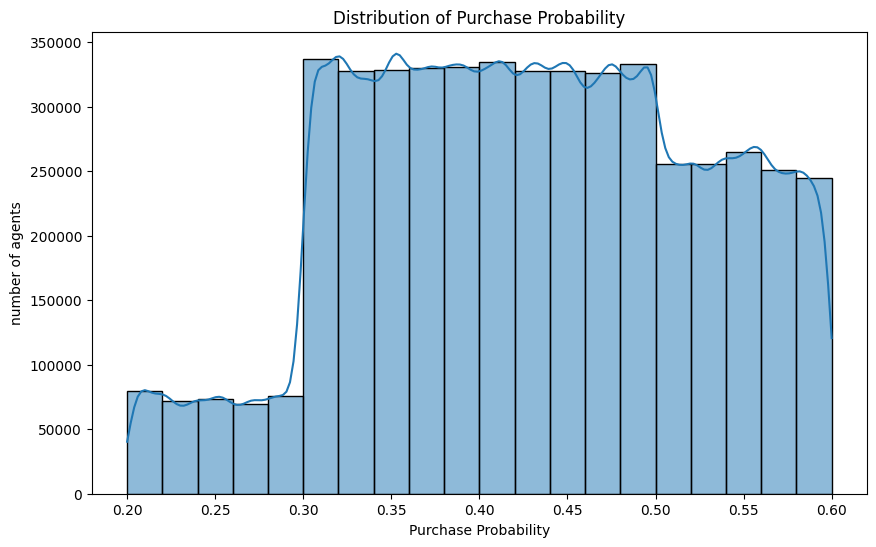

Total Purchases: 2112125


In [12]:
results = baseline_model.datacollector.get_agent_vars_dataframe()
print(results.head())
    # Visualize purchases
plt.figure(figsize=(10, 6))
sns.histplot(results['Purchases'], bins=20, kde=True)
plt.title('Distribution of Purchase Probability')
plt.xlabel('Purchase Probability')
plt.ylabel('number of agents')
plt.show()

# Display total purchases made
print(f"Total Purchases: {baseline_model.total_purchases}")

In [13]:
print("\n--- Running Unit Tests ---")
unittest.main(argv=['first-arg-is-ignored'], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.020s

OK



--- Running Unit Tests ---
